<a href="https://colab.research.google.com/github/Melsves/Klokkies2023/blob/master/Klokjes_statistieken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:



import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from collections import defaultdict
from itertools import permutations,groupby
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from collections import defaultdict
import sys
sys.path.append('/content/drive/MyDrive/klokkies/')
import klokjesfuncs


# Main execution
save_folder = '/content/drive/MyDrive/klokkies/'
file_path = '/content/drive/MyDrive/klokkies/Klokkendata.json'
data = pd.DataFrame(klokjesfuncs.load_json_data(file_path))
# Prepare the data
data = klokjesfuncs.prepare_data(data)


datay = data[data['datetime'].dt.year == 2023]
datay.head()

,sender,color,official,datetime
15416,Djes,purple,true,2023-01-01 01:11:19
15417,Rogier,red,true,2023-01-01 01:22:50
15418,Manon,red,true,2023-01-01 01:34:28
15419,Mels,red,true,2023-01-01 01:37:23
15420,Luke,purple,true,2023-01-01 01:43:29


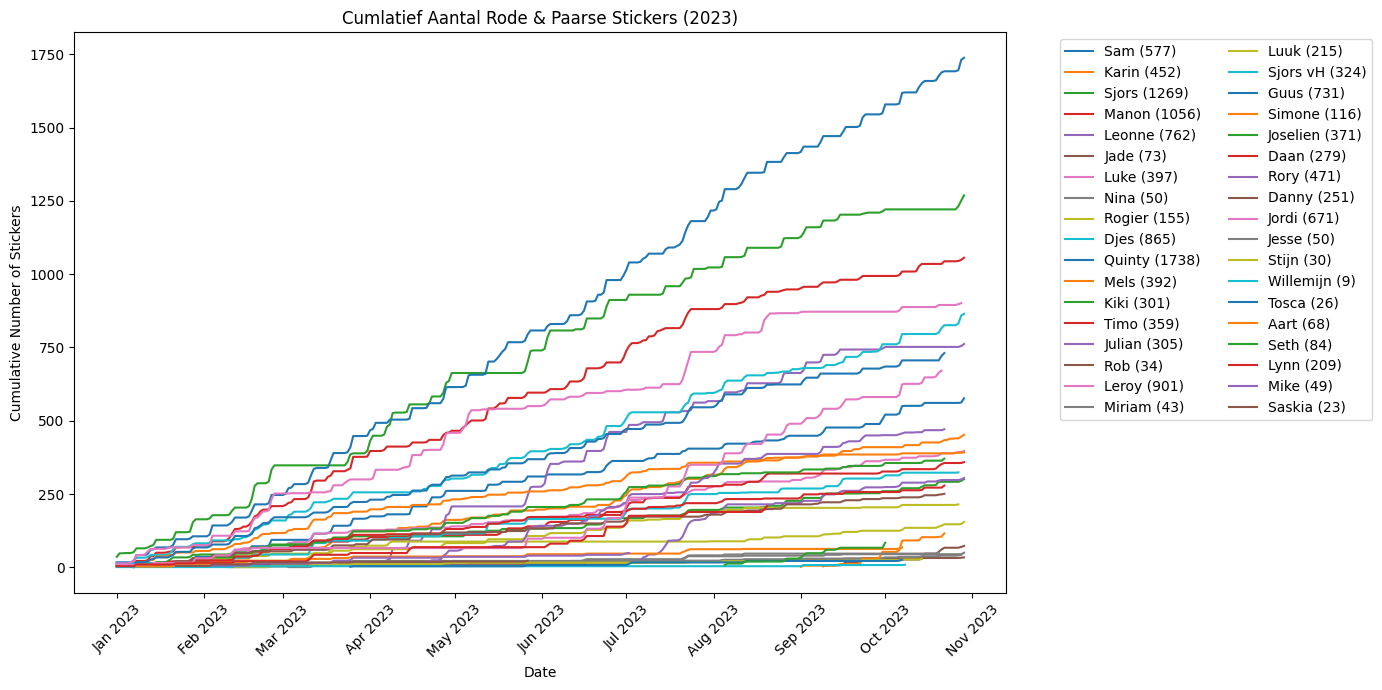

In [26]:

# Plot cumulative counts for red and purple stickers in 2023
klokjesfuncs.plot_cumulative_counts(data, 'Cumulatief Aantal Rode & Paarse Stickers (2023)', color_filter=['red', 'purple'], year_filter=2023)



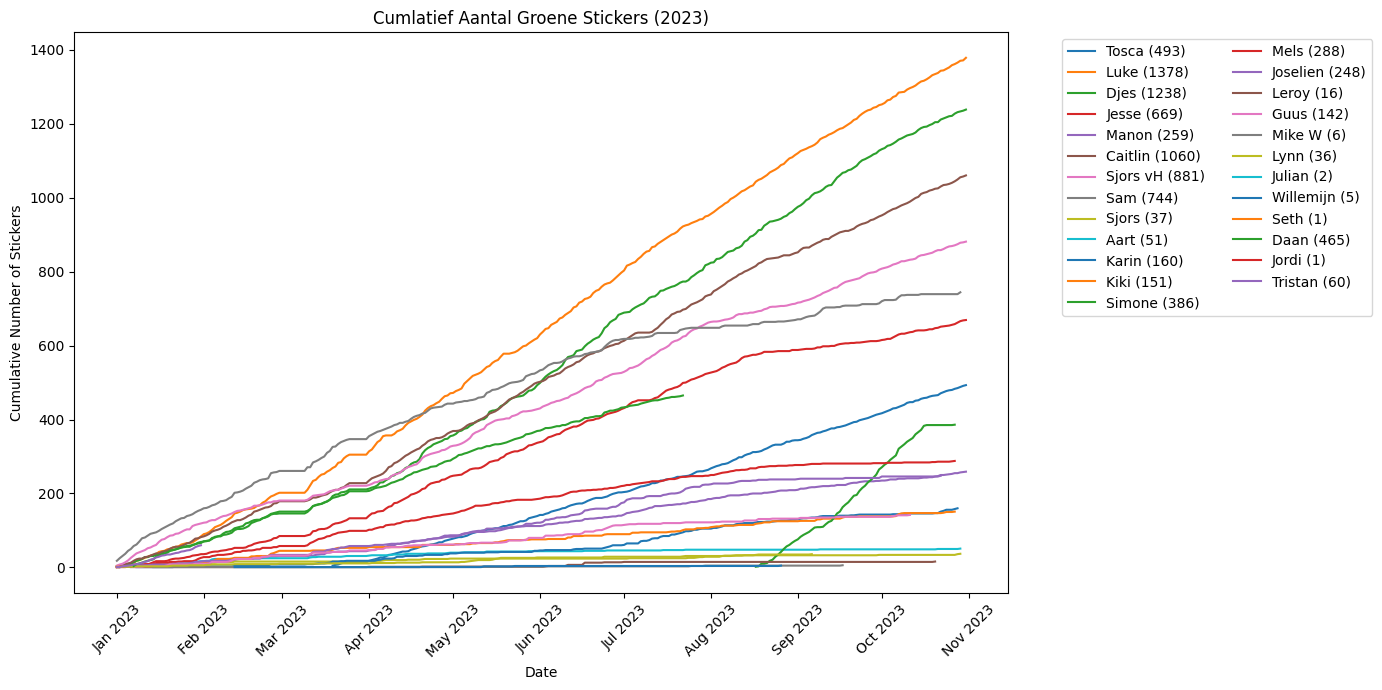

In [27]:
# Plot cumulative counts for green stickers in 2023
klokjesfuncs.plot_cumulative_counts(data, 'Cumulatief Aantal Groene Stickers (2023)', color_filter=['green'], year_filter=2023)





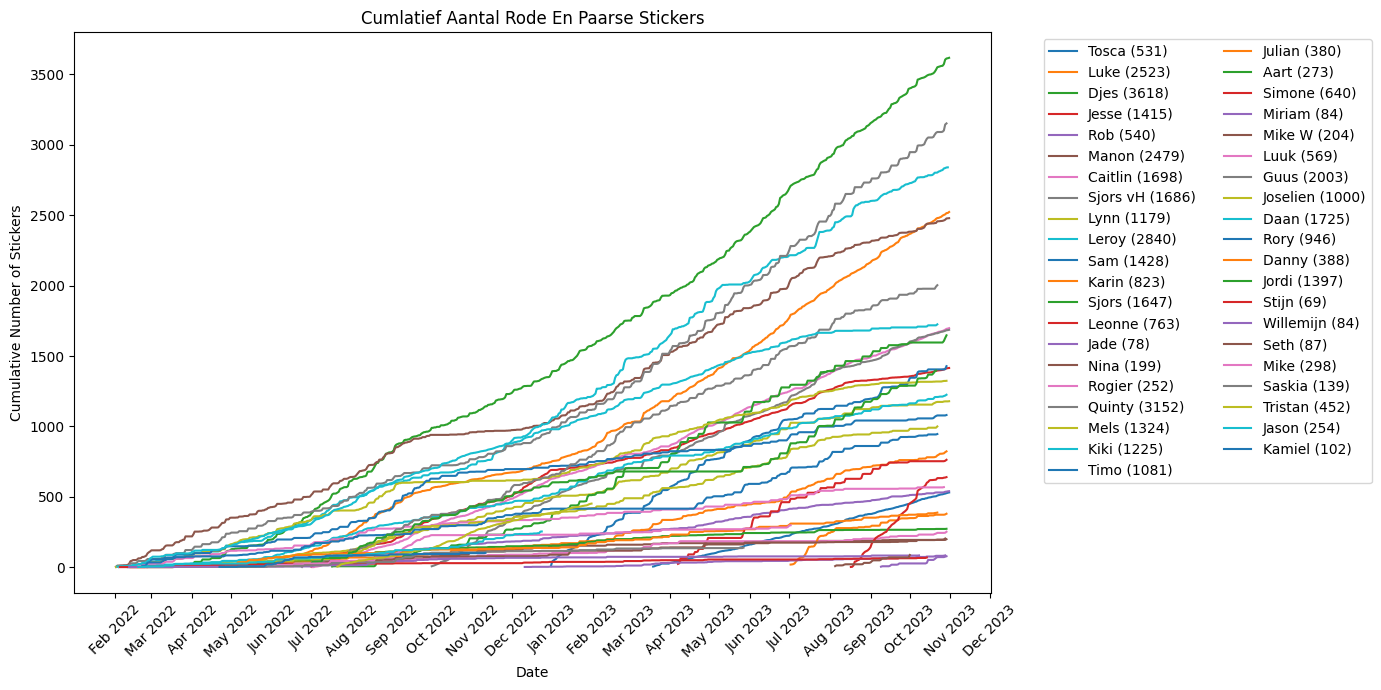

In [28]:
# Plot cumulative counts for all stickers
klokjesfuncs.plot_cumulative_counts(data, 'Cumulatief Aantal Rode En Paarse Stickers')



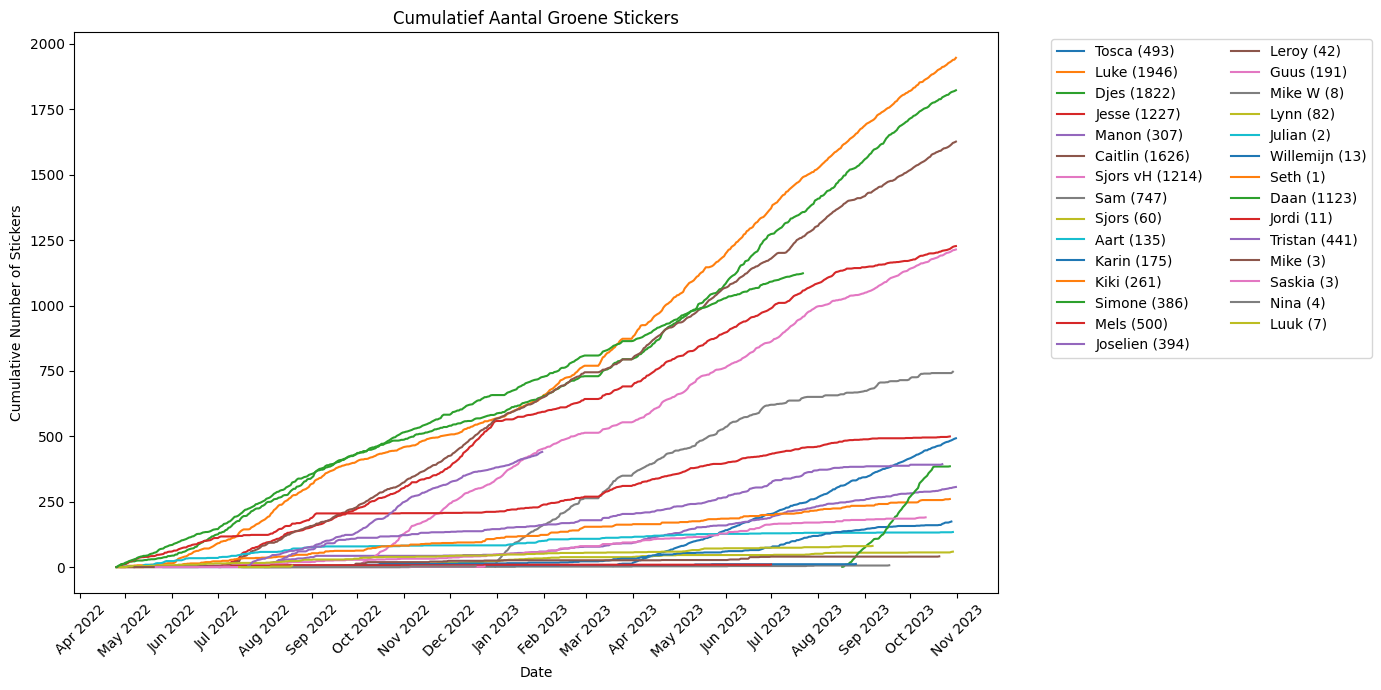

In [97]:
# Plot cumulative counts for green stickers
klokjesfuncs.plot_cumulative_counts(data, 'Cumulatief Aantal Groene Stickers', color_filter=['green'])



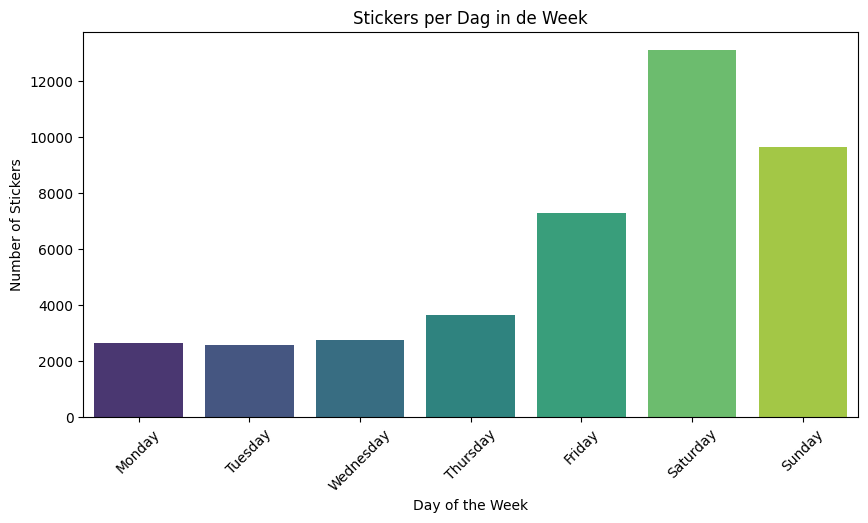

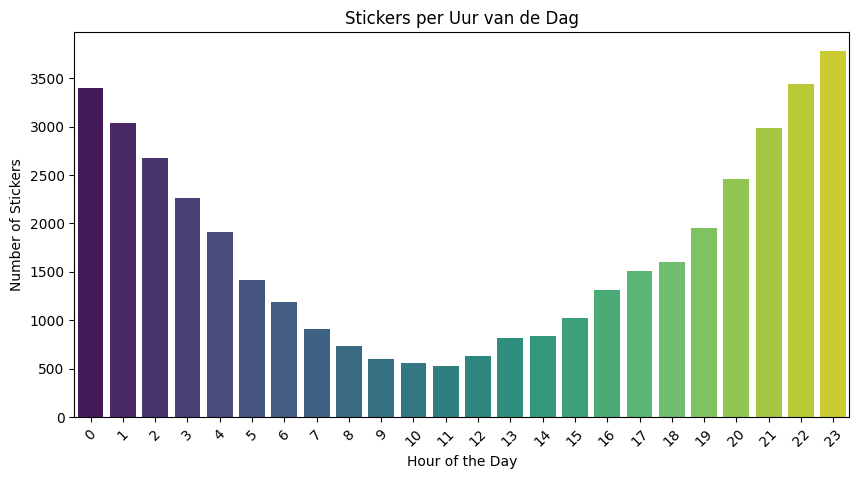

In [30]:

# Calculate and display sticker discos
sticker_disco_count, last_sticker_user_count = klokjesfuncs.calculate_sticker_discos(data)
# Output the results as needed, can be integrated into a visualization if desired

# Plot patterns by day and hour
klokjesfuncs.plot_patterns(data, 'Stickers per Dag in de Week', 'Stickers per Uur van de Dag')




In [31]:
# Output the results as needed, can be integrated into a visualization if desired
# Function to calculate the most frequently used color for each user
def get_color_preferences(df):
    # Calculate the most frequently used color for each user
    user_color_preferences = df.groupby('sender')['color'].agg(lambda x: x.value_counts().index[0])

    # Calculate the overall most popular color in the data
    overall_popular_color = df['color'].value_counts().idxmax()

    return user_color_preferences, overall_popular_color

# Get and display color preferences
user_color_preferences, overall_popular_color = get_color_preferences(data)
user_color_preferences, overall_popular_color

(sender
 Aart          green
 Caitlin       green
 Daan          green
 Danny           red
 Djes          green
 Guus            red
 Jade            red
 Jason        yellow
 Jesse         green
 Jordi           red
 Joselien        red
 Julian          red
 Kamiel       yellow
 Karin           red
 Kiki            red
 Leonne          red
 Leroy        yellow
 Luke          green
 Luuk            red
 Lynn         yellow
 Manon           red
 Mels            red
 Mike         yellow
 Mike W       yellow
 Miriam          red
 Nina            red
 Quinty          red
 Rob          yellow
 Rogier          red
 Rory            red
 Sam           green
 Saskia          red
 Seth            red
 Simone        green
 Sjors           red
 Sjors vH      green
 Stijn           red
 Timo            red
 Tosca         green
 Tristan       green
 Willemijn    yellow
 Name: color, dtype: object,
 'red')

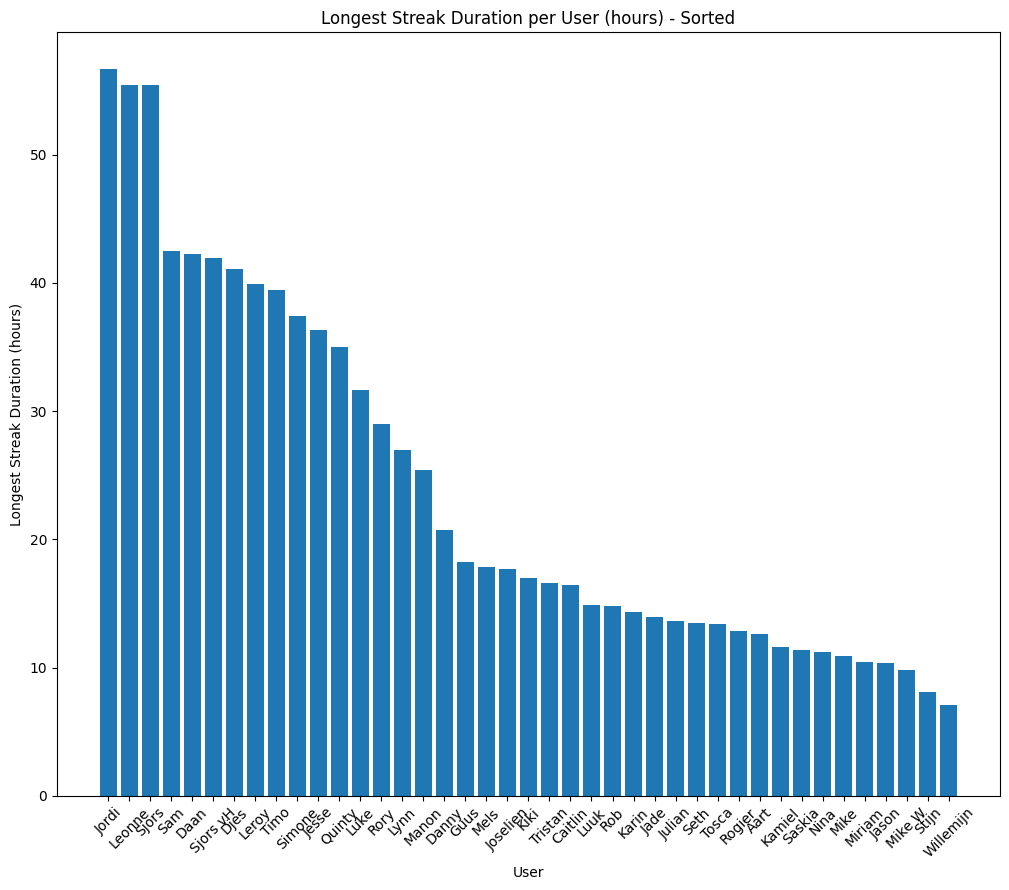

In [32]:
# Plot the longest streaks for all users
klokjesfuncs.plot_longest_streaks(data, 'Longest Streak Duration per User (hours) - Sorted')

In [33]:


# Calculate color matches for each user using the DataFrame that we previously prepared
color_matches = klokjesfuncs.calculate_color_matches(datay)

# Display the top 3 color matches for each user
top_color_matches = {user: matches for user, matches in color_matches.items() if matches}

# Display top 3 color matches for a few users as a sample
{user: top_color_matches[user] for user in list(top_color_matches)[:]}  # Displaying all users


{'Manon': [('Mels', 200), ('Quinty', 198), ('Djes', 150)],
 'Luke': [('Djes', 131), ('Manon', 97), ('Mels', 86)],
 'Sam': [('Quinty', 105), ('Manon', 102), ('Djes', 83)],
 'Sjors vH': [('Quinty', 72), ('Djes', 56), ('Manon', 56)],
 'Djes': [('Luke', 162), ('Guus', 160), ('Manon', 156)],
 'Lynn': [('Quinty', 63), ('Djes', 54), ('Guus', 49)],
 'Sjors': [('Leonne', 443), ('Quinty', 109), ('Djes', 75)],
 'Quinty': [('Manon', 260), ('Djes', 200), ('Guus', 182)],
 'Nina': [('Leroy', 9), ('Sam', 8), ('Joselien', 7)],
 'Guus': [('Quinty', 121), ('Djes', 119), ('Manon', 110)],
 'Leroy': [('Quinty', 137), ('Djes', 129), ('Guus', 111)],
 'Kiki': [('Sam', 64), ('Guus', 58), ('Djes', 54)],
 'Rogier': [('Guus', 19), ('Sam', 16), ('Karin', 14)],
 'Willemijn': [('Djes', 2), ('Daan', 2), ('Luke', 1)],
 'Jordi': [('Quinty', 73), ('Djes', 57), ('Guus', 47)],
 'Mels': [('Manon', 119), ('Djes', 72), ('Quinty', 65)],
 'Rob': [('Quinty', 35), ('Leroy', 22), ('Djes', 22)],
 'Caitlin': [('Jesse', 251), ('Djes'

In [34]:
# Calculate the most frequently used color for each user
user_color_preferences = datay.groupby('sender')['color'].agg(lambda x: x.value_counts().index[0])

# Calculate the overall most popular color in the group chat
overall_popular_color = datay['color'].value_counts().idxmax()

# Display the color preferences for the first few users
user_color_preferences, overall_popular_color


(sender
 Aart            red
 Caitlin       green
 Daan          green
 Danny           red
 Djes          green
 Guus            red
 Jade            red
 Jesse         green
 Jordi           red
 Joselien        red
 Julian          red
 Karin           red
 Kiki            red
 Leonne          red
 Leroy        yellow
 Luke          green
 Luuk            red
 Lynn         yellow
 Manon           red
 Mels            red
 Mike            red
 Mike W       yellow
 Miriam          red
 Nina            red
 Quinty          red
 Rob          yellow
 Rogier          red
 Rory            red
 Sam           green
 Saskia          red
 Seth            red
 Simone        green
 Sjors           red
 Sjors vH      green
 Stijn           red
 Timo            red
 Tosca         green
 Tristan       green
 Willemijn    purple
 Name: color, dtype: object,
 'red')

In [35]:


# Count all 'sticker discos' and the last user
sticker_disco_count, last_sticker_user_count = klokjesfuncs.count_sticker_discos_and_last_user(datay)

# Output the number of 'sticker discos' and the sorted list of users who sent the last sticker most often
sticker_disco_count, last_sticker_user_count


(183,
 [('Leroy', 23),
  ('Guus', 14),
  ('Sam', 12),
  ('Luke', 12),
  ('Quinty', 9),
  ('Lynn', 9),
  ('Caitlin', 8),
  ('Karin', 8),
  ('Sjors vH', 8),
  ('Miriam', 8),
  ('Kiki', 7),
  ('Djes', 6),
  ('Timo', 5),
  ('Daan', 5),
  ('Rory', 5),
  ('Simone', 5),
  ('Sjors', 4),
  ('Mels', 4),
  ('Julian', 4),
  ('Jesse', 3),
  ('Rob', 3),
  ('Manon', 3),
  ('Tosca', 3),
  ('Danny', 2),
  ('Mike W', 2),
  ('Aart', 2),
  ('Nina', 1),
  ('Jordi', 1),
  ('Saskia', 1),
  ('Rogier', 1),
  ('Joselien', 1),
  ('Luuk', 1),
  ('Willemijn', 1),
  ('Seth', 1),
  ('Jade', 1)])

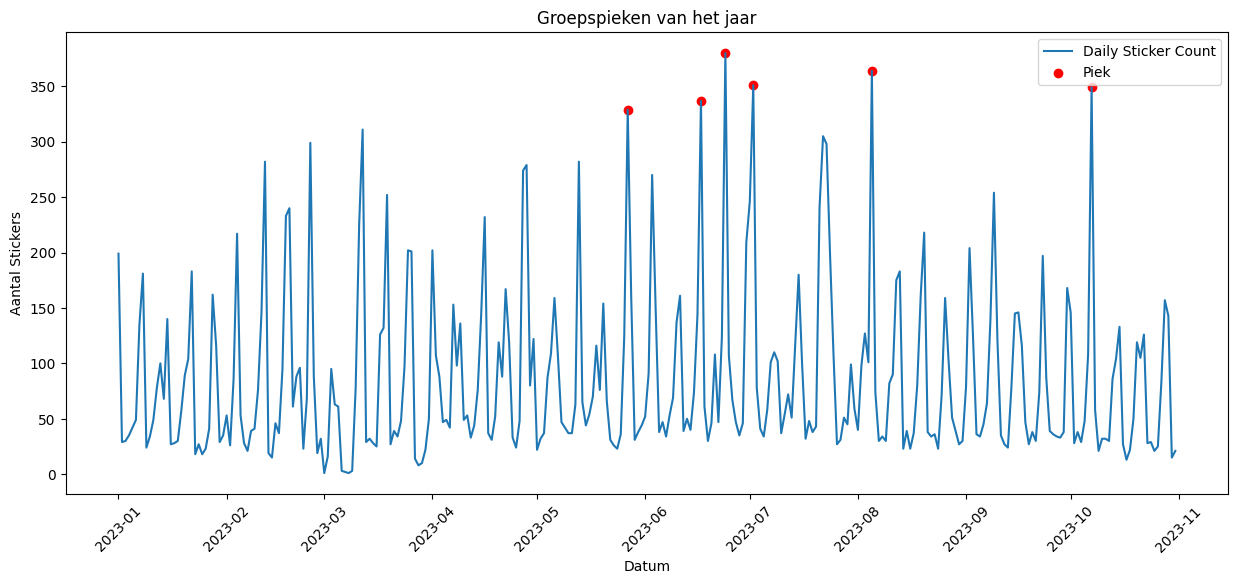

datetime
2023-05-27    329
2023-06-17    337
2023-06-24    380
2023-07-02    351
2023-08-05    364
2023-10-07    349
dtype: int64

In [37]:
from scipy import stats
import numpy as np

# Aggregating sticker data by date for the entire dataset
daily_stickers = datay.groupby(data['datetime'].dt.date).size()

# Calculate Z-scores for the daily sticker count
z_scores = stats.zscore(daily_stickers)

# Identify anomalies (here we're using a threshold of 3 standard deviations)
anomalies = daily_stickers[(np.abs(z_scores) > 3)]

# Plot the daily sticker count with anomalies highlighted
plt.figure(figsize=(15, 6))
plt.plot(daily_stickers.index, daily_stickers.values, label='Daily Sticker Count')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Piek')
plt.title('Groepspieken van het jaar')
plt.xlabel('Datum')
plt.ylabel('Aantal Stickers')
plt.xticks(rotation=45)
plt.legend()
plt.show()

anomalies


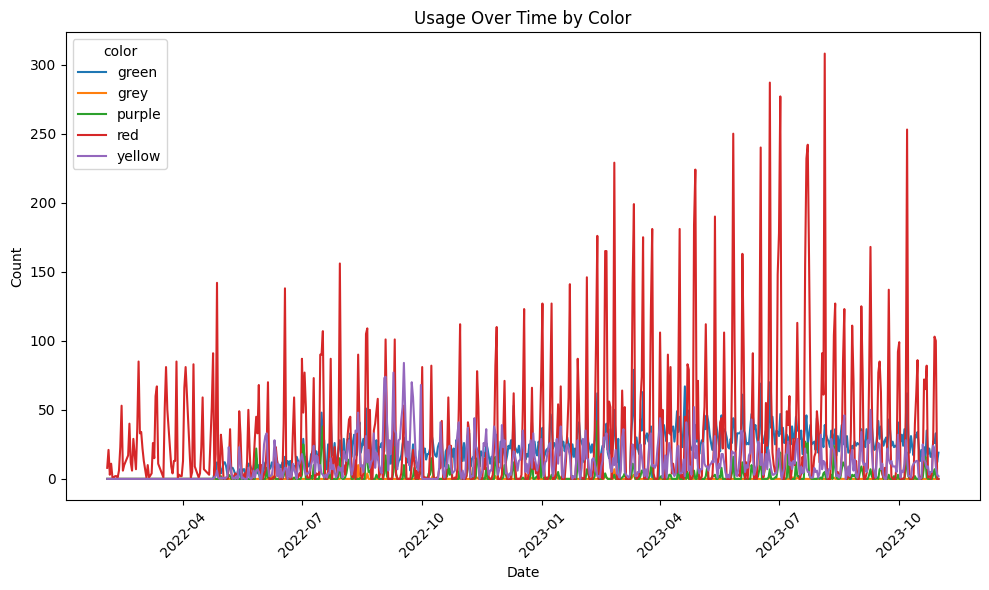

In [38]:
# Aggregate data by date and color
usage_over_time = data.groupby([data['datetime'].dt.date, 'color']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Set the size of the plot
usage_over_time.plot(kind='line', ax=ax)  # This will create one line per color automatically

# Enhancing the plot
ax.set_title('Usage Over Time by Color')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

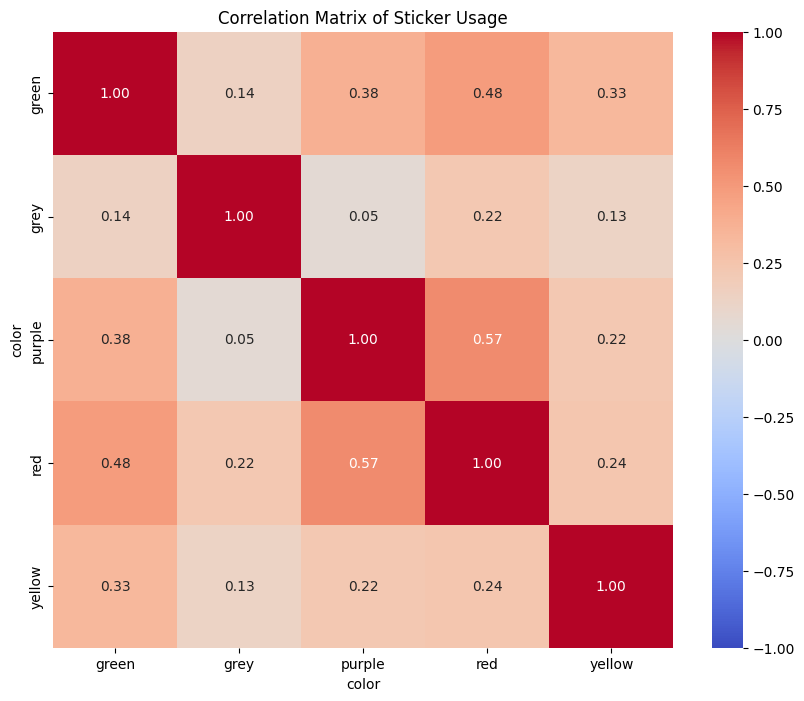

In [39]:
import seaborn as sns
# Compute the correlation matrix for sticker usage
correlation_matrix = usage_over_time.corr()
# Visualize the correlation matrix again
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Sticker Usage')
plt.show()




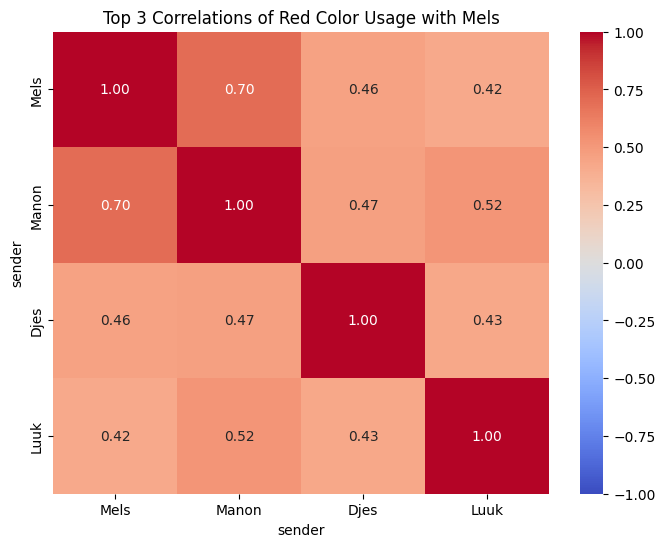

In [40]:
# Aggregate data by date and sender for 'red' color stickers only

red_usage_by_user = data[data['color'] == 'red'].groupby(

    [data['datetime'].dt.date, 'sender']).size().unstack(fill_value=0)



# Compute the correlation matrix for 'red' color usage between different users

correlation_matrix_red = red_usage_by_user.corr()

# Identify the top 3 users with the highest correlation in red color usage with 'Mels'
mels_correlation = correlation_matrix_red['Mels'].drop('Mels')  # Drop self-correlation
top3_correlated_users = mels_correlation.abs().sort_values(ascending=False).head(3).index.tolist()

# Select only 'Mels' and the top 3 correlated users
top_correlations_red = correlation_matrix_red.loc[['Mels'] + top3_correlated_users, ['Mels'] + top3_correlated_users]

# Visualize the correlation matrix for 'red' color for 'Mels' and the top 3 correlated users
plt.figure(figsize=(8, 6))
sns.heatmap(top_correlations_red, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Top 3 Correlations of Red Color Usage with Mels')
plt.show()

In [44]:
# Function to find co-usage patterns within a day for a user
def find_co_usage_patterns(data, time_window='1H'):
    co_usage_counts = {}

    # Group by user and date
    grouped_data = data.groupby(['sender', data['datetime'].dt.date])

    for _, group in grouped_data:
        # Resample the data within each day according to the time window
        resampled_group = group.groupby(pd.Grouper(key='datetime', freq=time_window))

        for _, window_group in resampled_group:
            clocks_used = window_group['color'].unique()
            if len(clocks_used) > 1:
                # If more than one clock is used in the time window, count the co-usage
                co_usage = tuple(sorted(clocks_used))
                co_usage_counts[co_usage] = co_usage_counts.get(co_usage, 0) + 1

    return co_usage_counts

# Find co-usage patterns with a 1-hour time window
co_usage_patterns = find_co_usage_patterns(data, time_window='1H')

# Sort and display the most common co-usage patterns
sorted_co_usage_patterns = sorted(co_usage_patterns.items(), key=lambda item: item[1], reverse=True)
sorted_co_usage_patterns[:10]  # Display the top 10 most common co-usage patterns


[(('green', 'red'), 1227),
 (('red', 'yellow'), 631),
 (('purple', 'red'), 323),
 (('green', 'yellow'), 237),
 (('green', 'purple'), 54),
 (('green', 'red', 'yellow'), 54),
 (('purple', 'yellow'), 42),
 (('grey', 'red'), 22),
 (('green', 'purple', 'red'), 19),
 (('purple', 'red', 'yellow'), 17)]

In [45]:
# Function to analyze user-specific patterns
def analyze_user_patterns(user_data):
    user_patterns = {}

    # Calculate the most frequently used clock
    clock = user_data['color'].mode().iloc[0]
    user_patterns['Favorite clock'] = clock

    # Calculate the most common day of the week for clock use
    favorite_day = user_data['datetime'].dt.day_name().mode().iloc[0]
    user_patterns['Favorite Day'] = favorite_day

    # Calculate the most common hour of the day for clock use
    favorite_hour = user_data['datetime'].dt.hour.mode().iloc[0]
    user_patterns['Favorite Hour'] = f"{favorite_hour}:00-{favorite_hour+1}:00"

    return user_patterns

# Analyze patterns for a few random users
random_users = np.random.choice(data['sender'].unique(), 30, replace=False)
user_specific_patterns = {user: analyze_user_patterns(data[data['sender'] == user]) for user in random_users}

user_specific_patterns


{'Rogier': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '1:00-2:00'},
 'Sjors vH': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '16:00-17:00'},
 'Tristan': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '20:00-21:00'},
 'Kamiel': {'Favorite clock': 'yellow',
  'Favorite Day': 'Friday',
  'Favorite Hour': '0:00-1:00'},
 'Aart': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '1:00-2:00'},
 'Willemijn': {'Favorite clock': 'yellow',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '20:00-21:00'},
 'Kiki': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '21:00-22:00'},
 'Simone': {'Favorite clock': 'green',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '23:00-24:00'},
 'Jason': {'Favorite clock': 'yellow',
  'Favorite Day': 'Saturday',
  'Favorite Hour': '21:00-22:00'},
 'Mels': {'Favorite clock': 'red',
  'Favorite Day': 'Saturday',
  'Favo

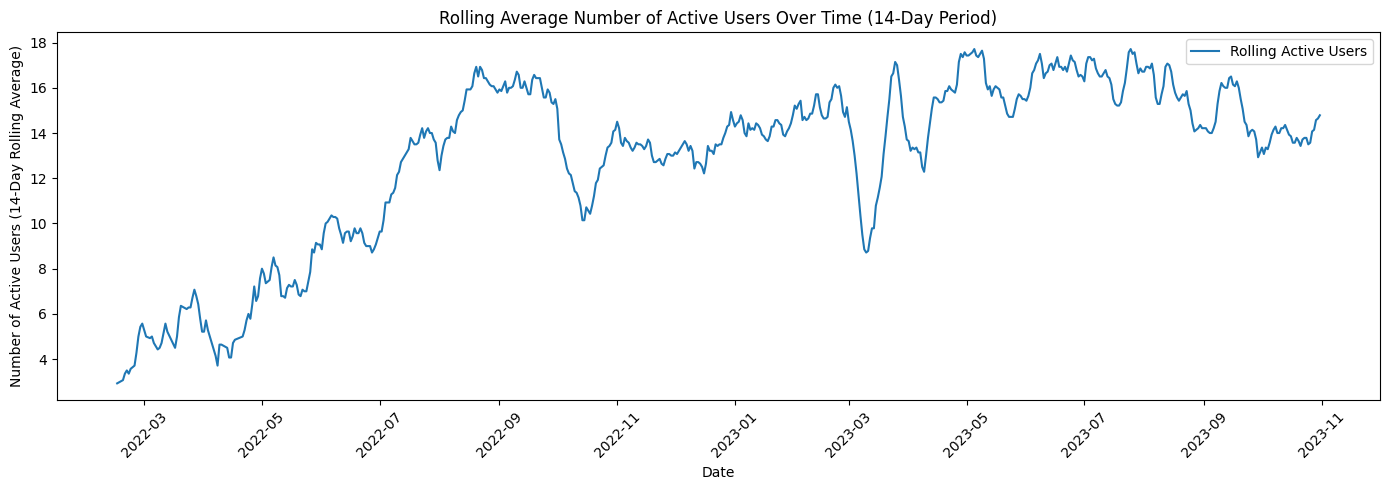

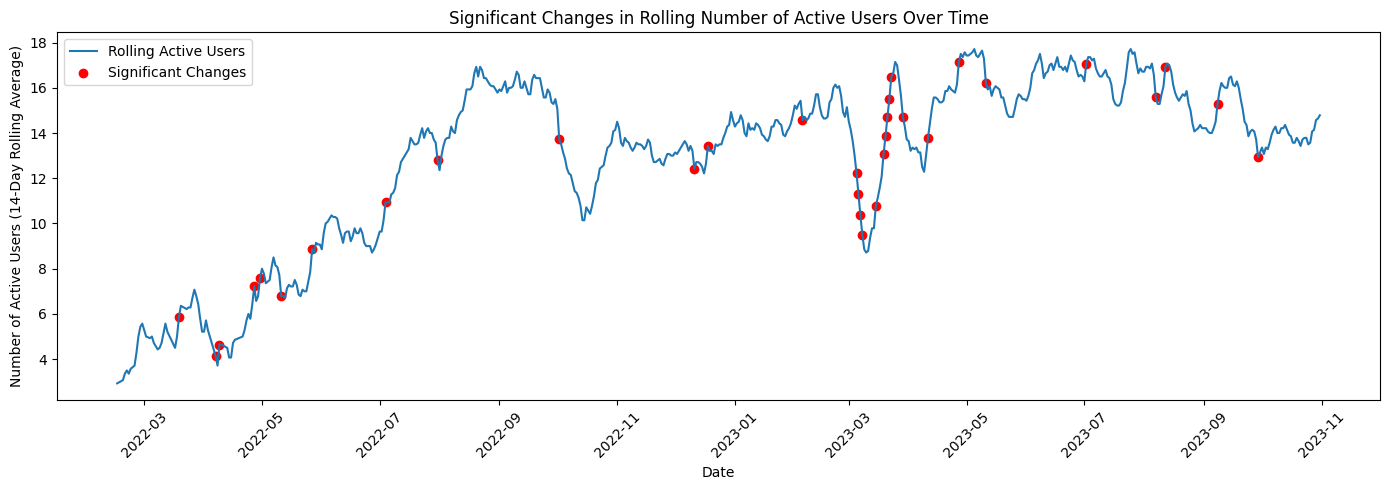

In [54]:
# Define active users based on a rolling period of 30 days
rolling_active_users = data.groupby(data['datetime'].dt.to_period("D"))['sender'].nunique().rolling(window=14).mean().dropna()

# Convert to a time series with dates as the index
rolling_active_users.index = rolling_active_users.index.to_timestamp()
ts_rolling_active_users = pd.Series(rolling_active_users, index=rolling_active_users.index)

# Plot the rolling number of active users over time
plt.figure(figsize=(14, 5))
plt.title('Rolling Average Number of Active Users Over Time (14-Day Period)')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (14-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Re-evaluate significant changes with the new definition
mean_rolling_change = ts_rolling_active_users.diff().mean()
std_rolling_change = ts_rolling_active_users.diff().std()
significant_rolling_changes = ts_rolling_active_users.diff().abs()/2 > (mean_rolling_change + std_rolling_change)

# Plotting the significant changes with the new definition
plt.figure(figsize=(14, 5))
plt.title('Significant Changes in Rolling Number of Active Users Over Time')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.scatter(ts_rolling_active_users[significant_rolling_changes].index, ts_rolling_active_users[significant_rolling_changes], color='red', label='Significant Changes')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (14-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


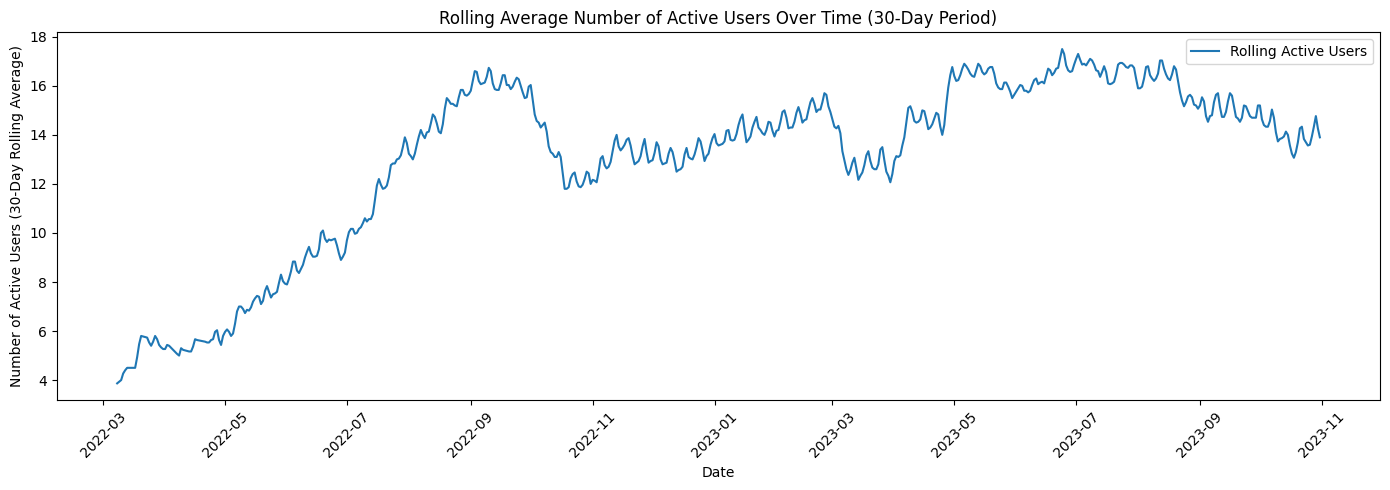

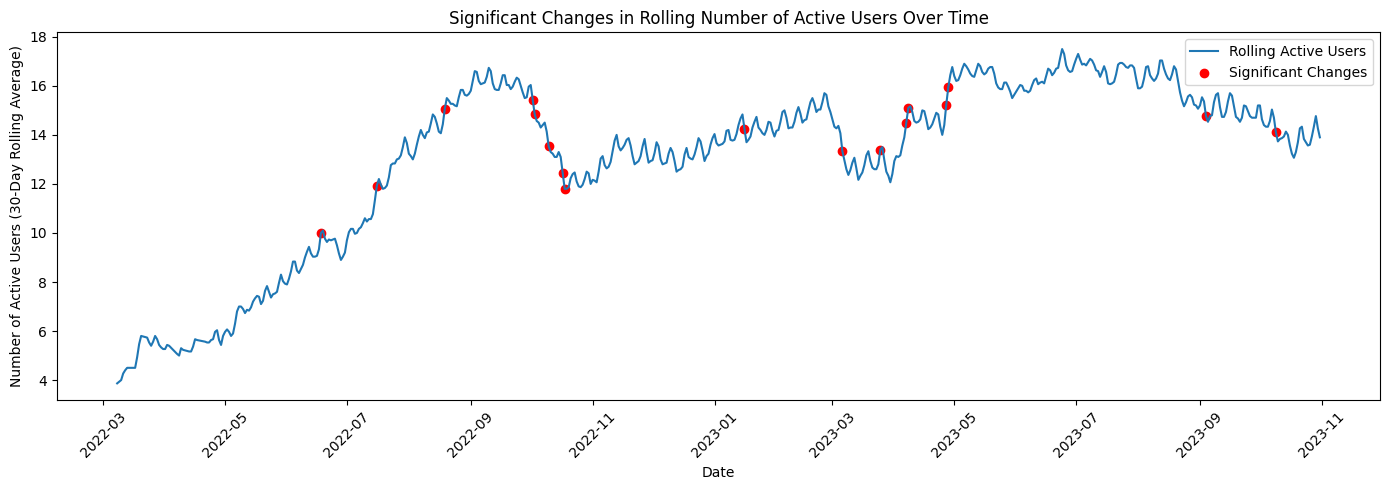

In [55]:
# Define active users based on a rolling period of 30 days
rolling_active_users = data.groupby(data['datetime'].dt.to_period("D"))['sender'].nunique().rolling(window=30).mean().dropna()

# Convert to a time series with dates as the index
rolling_active_users.index = rolling_active_users.index.to_timestamp()
ts_rolling_active_users = pd.Series(rolling_active_users, index=rolling_active_users.index)

# Plot the rolling number of active users over time
plt.figure(figsize=(14, 5))
plt.title('Rolling Average Number of Active Users Over Time (30-Day Period)')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (30-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Re-evaluate significant changes with the new definition
mean_rolling_change = ts_rolling_active_users.diff().mean()
std_rolling_change = ts_rolling_active_users.diff().std()
significant_rolling_changes = ts_rolling_active_users.diff().abs()/2 > (mean_rolling_change + std_rolling_change)

# Plotting the significant changes with the new definition
plt.figure(figsize=(14, 5))
plt.title('Significant Changes in Rolling Number of Active Users Over Time')
plt.plot(ts_rolling_active_users, label='Rolling Active Users')
plt.scatter(ts_rolling_active_users[significant_rolling_changes].index, ts_rolling_active_users[significant_rolling_changes], color='red', label='Significant Changes')
plt.xlabel('Date')
plt.ylabel('Number of Active Users (30-Day Rolling Average)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
d

In [94]:
# Sort the data by 'sender' and 'datetime'
data_sorted = datay.sort_values(['sender', 'datetime'])

# Calculate the gap in days between each sticker
data_sorted['next_datetime'] = data_sorted.groupby('sender')['datetime'].shift(-1)
data_sorted['gap'] = (data_sorted['next_datetime'] - data_sorted['datetime']).dt.days

# Set the gap to 7 days if the next sticker is sent after more than 7 days or if it's the last sticker
data_sorted['gap'] = data_sorted['gap'].apply(lambda x: 7 if x is pd.NaT or x > 7 else x)

# Now calculate the total active days for each user
# We'll start by assuming each sticker means the user is active for 7 days
# Then we subtract the gap for stickers followed by another within 7 days
data_sorted['active_days'] = 7 - data_sorted['gap'].fillna(7)





In [96]:
# Initialize a dictionary to hold the sets of active days for each user
active_days_per_user = defaultdict(set)

# Loop through each row in the data
for _, row in data_sorted.iterrows():
    if row['color'] == 'red':
        # Generate the set of active days for each sticker
        active_days = {row['datetime'].date() + timedelta(days=i) for i in range(7)}
        # Add these days to the user's set of active days
        active_days_per_user[row['sender']].update(active_days)

# Calculate the number of unique active days for each user
unique_active_days = {user: len(days) for user, days in active_days_per_user.items()}

# Find the user with the longest and shortest total active period
longest_active_user = max(unique_active_days, key=unique_active_days.get)
shortest_active_user = min(unique_active_days, key=unique_active_days.get)

# Print out the identified users
print(f"User with the longest total active period: {longest_active_user}, Active days: {unique_active_days[longest_active_user]}")
print(f"User with the shortest total active period: {shortest_active_user}, Active days: {unique_active_days[shortest_active_user]}")


User with the longest total active period: Quinty, Active days: 308
User with the shortest total active period: Tosca, Active days: 14
